In [3]:
# --- Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import pickle


In [4]:
# --- Load Data ---
df = pd.read_csv("creditcard.csv")
print(df.head())



   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [5]:
# --- Split ---
X = df.drop("Class", axis=1)
y = df["Class"]

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)



In [6]:
# Balance data
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

# --- Train XGBoost ---
clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss")
clf.fit(X_res, y_res)




/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:29:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [9]:
# Save model
import os
import pickle
os.makedirs("../models", exist_ok=True)
with open("../models/xgboost_model.pkl", "wb") as f:
    pickle.dump(clf, f)

pickle.dump(clf, open("../models/xgboost_model.pkl", "wb"))



[[56844    20]
 [   13    85]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.81      0.87      0.84        98

    accuracy                           1.00     56962
   macro avg       0.90      0.93      0.92     56962
weighted avg       1.00      1.00      1.00     56962



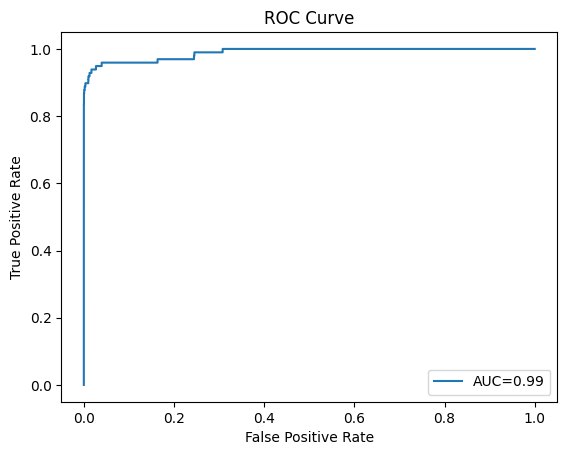

In [8]:
# --- Evaluation ---
y_pred = clf.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label=f"AUC={auc(fpr,tpr):.2f}")
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()